In [ ]:
from google.colab import drive
drive.mount('/content/drive')

import sys
sys.path.append('/content/drive/My Drive/Colab_Notebooks/RL')
import sys
import os

# Set the working directory
os.chdir('/content/drive/My Drive/Colab_Notebooks/RL')

# test
from simulator import GlassformSimulator

Mounted at /content/drive


In [ ]:
!pip install stable-baselines3[extra]
!pip install 'shimmy>=2.0'

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 34.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 958.1/958.1 kB 46.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 183.9/183.9 kB 14.1 MB/s eta 0:00:00


Environment with both cooling and contact

In [ ]:
import gym
from gym import spaces
import numpy as np
from simulator import GlassformSimulator

class ParisonControlEnvTgobDisturbance(gym.Env):
    def __init__(self, simulator, target_T_parison):
        super(ParisonControlEnvTgobDisturbance, self).__init__()
        self.simulator = simulator
        self.target_T_parison = target_T_parison  # Target temperature

        # Action space for adjustments to t_settle, t_counter, and t_cooling
        self.action_space = spaces.Box(low=-1.0, high=1.0, shape=(3,), dtype=np.float32)

        # Observation space: [T_parison, T_mold, t_contact, T_gob, t_cooling]
        self.observation_space = spaces.Box(
            low=np.array([900, 350, 2.10 + 1.44, 1123, 4.08]),  # [T_parison, T_mold, t_contact, T_gob, t_cooling]
            high=np.array([1100, 400, 2.56 + 1.74, 1127, 4.82]),
            dtype=np.float32
        )

        self.reset()

    def reset(self):
        # Reset simulator
        self.simulator.reset(T_mold=377.93)
        self.simulator.T_gob = np.random.uniform(1123, 1127)  # Randomized T_gob disturbance
        self.simulator.T_air = 50  # Fixed air temperature
        self.simulator.t_settle = 2.33
        self.simulator.t_counter = 1.59
        self.simulator.t_cooling = 4.45

        # Simulate one cycle to initialize
        self.simulator.simulate_cycle()
        self.current_step = 0
        return self._get_observation()

    def step(self, action):
        # Scale actions to actual adjustment ranges
        t_settle_adjustment = action[0] * 0.23
        t_counter_adjustment = action[1] * 0.15
        t_cooling_adjustment = action[2] * 0.37

        # Apply adjustments and clip to bounds
        self.simulator.t_settle = np.clip(2.33 + t_settle_adjustment, 2.10, 2.56)
        self.simulator.t_counter = np.clip(1.59 + t_counter_adjustment, 1.44, 1.74)
        self.simulator.t_cooling = np.clip(4.45 + t_cooling_adjustment, 4.08, 4.82)

        # Simulate one cycle
        self.simulator.simulate_cycle()

        # Log debug information
        print(f"Cycle {self.current_step}:")
        print(f"  T_parison = {self.simulator.T_parison}")
        print(f"  T_mold = {self.simulator.T_mold}")
        print(f"  T_gob = {self.simulator.T_gob}")
        print(f"  t_settle = {self.simulator.t_settle}")
        print(f"  t_counter = {self.simulator.t_counter}")
        print(f"  t_cooling = {self.simulator.t_cooling}")
        print(f"  T_air = {self.simulator.T_air}")

        # Get observations
        obs = self._get_observation()
        T_parison = self.simulator.T_parison

        # Calculate reward
        reward = -abs(T_parison - self.target_T_parison)

        # Check if done
        done = abs(T_parison - self.target_T_parison) < 0.5 or self.current_step >= 200
        self.current_step += 1

        return obs, reward, done, {}

    def _get_observation(self):
        return np.array([
            self.simulator.T_parison,
            self.simulator.T_mold,
            self.simulator.t_settle + self.simulator.t_counter,  # t_contact
            self.simulator.T_gob,
            self.simulator.t_cooling,
        ], dtype=np.float32)

In [ ]:
from stable_baselines3 import PPO
from stable_baselines3.common.env_util import make_vec_env

# Create the new environment with T_gob disturbance
env = ParisonControlEnvTgobDisturbance(simulator=GlassformSimulator(), target_T_parison=992.30)
env = make_vec_env(lambda: env, n_envs=1)

# Train the agent
model = PPO("MlpPolicy", env, ent_coef=0.01, verbose=1)
model.learn(total_timesteps=100000)
model.save("ppo_parison_control_with_tgob_variability")

/usr/local/lib/python3.10/dist-packages/gym/spaces/box.py:128: UserWarning: WARN: Box bound precision lowered by casting to float32
  logger.warn(f"Box bound precision lowered by casting to {self.dtype}")
/usr/local/lib/python3.10/dist-packages/stable_baselines3/common/vec_env/patch_gym.py:49: UserWarning: You provided an OpenAI Gym environment. We strongly recommend transitioning to Gymnasium environments. Stable-Baselines3 is automatically wrapping your environments in a compatibility layer, which could potentially cause issues.
  warnings.warn(


Streaming output truncated to the last 5000 lines.
  t_cooling = 4.313191940188408
  T_air = 50.0
Cycle 9:
  T_parison = 993.7649312156738
  T_mold = 379.14978338681897
  T_gob = 1126.9991128022689
  t_settle = 2.2487914001941682
  t_counter = 1.74
  t_cooling = 4.451607302576304
  T_air = 50.0
Cycle 10:
  T_parison = 994.054449280034
  T_mold = 378.95287385973563
  T_gob = 1126.9991128022689
  t_settle = 2.200490856766701
  t_counter = 1.74
  t_cooling = 4.561206857264042
  T_air = 50.0
Cycle 11:
  T_parison = 996.432314917009
  T_mold = 378.5650823638564
  T_gob = 1126.9991128022689
  t_settle = 2.1
  t_counter = 1.74
  t_cooling = 4.644415702819824
  T_air = 50.0
Cycle 12:
  T_parison = 993.9306108281551
  T_mold = 378.6597706141734
  T_gob = 1126.9991128022689
  t_settle = 2.179853636622429
  t_counter = 1.74
  t_cooling = 4.394858453422785
  T_air = 50.0
Cycle 13:
  T_parison = 992.283253259647
  T_mold = 378.8233082267247
  T_gob = 1126.9991128022689
  t_settle = 2.23519483536481

Steady state reached at cycle 110

Steady State Information:
Steady Point Cycle: 110
Steady Gob Temperature: 992.30°C
Steady Mold Temperature: 377.93°C

Disturbance applied: T_gob increased by 2°C.
Log data saved to /content/RL_Recovery_Log_Tgob.csv


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

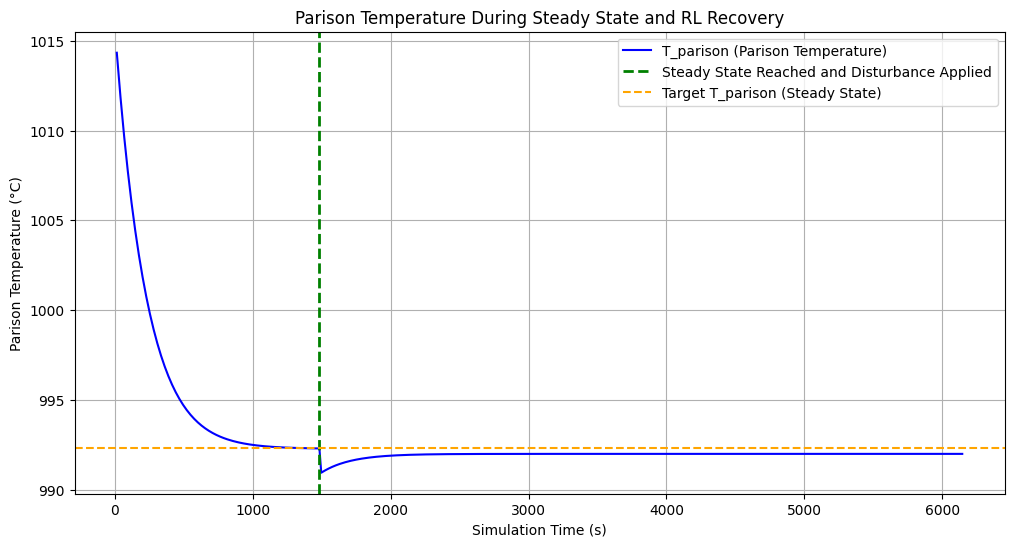

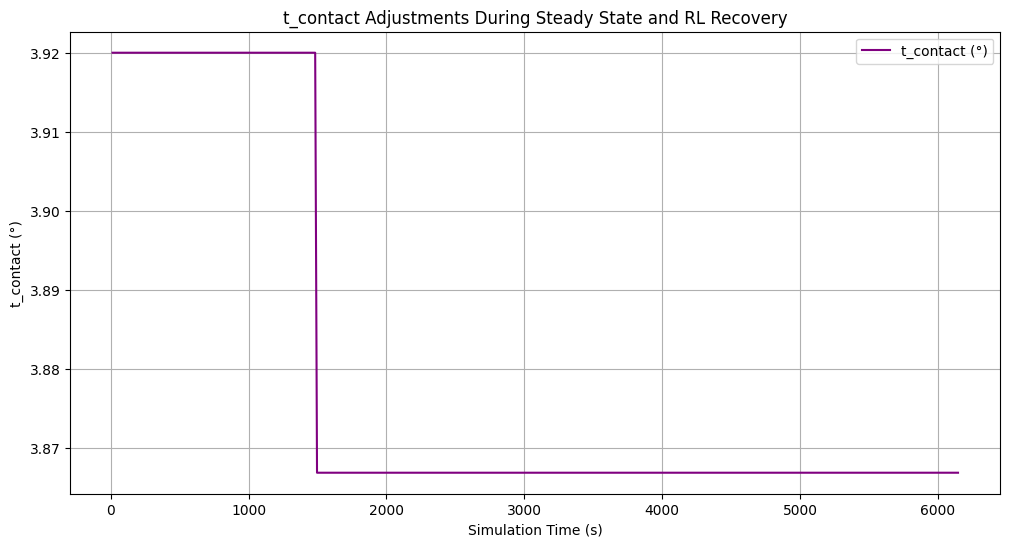

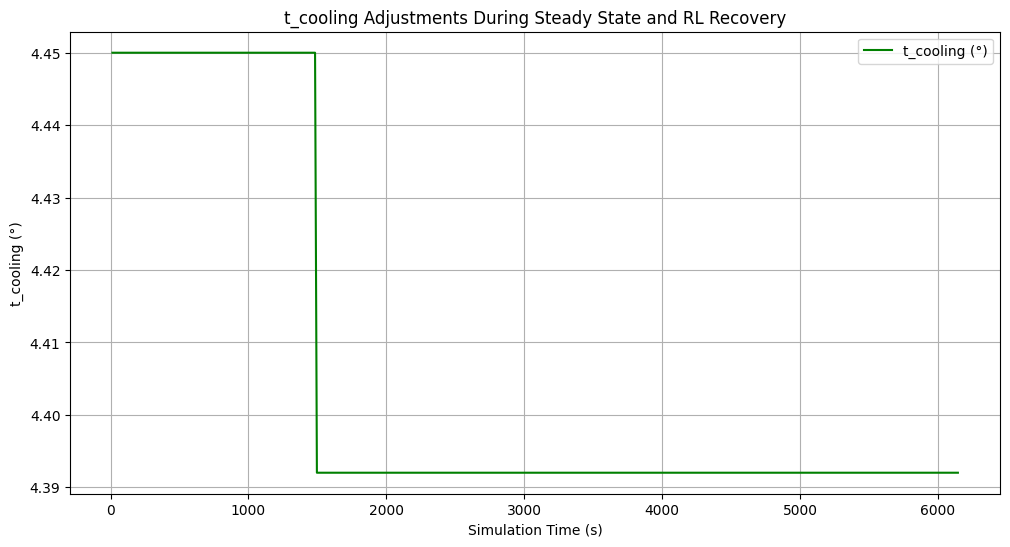

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from stable_baselines3 import PPO
from simulator import GlassformSimulator

# Constants
CYCLE_LENGTH_S = 13.36  # Total cycle length in seconds
STEADY_WINDOW = 50  # Number of cycles for steady-state detection
SLOPE_THRESHOLD = 0.01  # Threshold for steady-state slope

# Initialize the simulator
simulator = GlassformSimulator()
simulator.reset(T_mold=400.5)
simulator.T_gob = 1125  # Initial T_gob
simulator.T_air = 50  # Fixed T_air
simulator.t_settle = 2.33
simulator.t_counter = 1.59
simulator.t_cooling = 4.45

# Placeholder for results
gob_temps = []  # Parison temperature (T_gob)
mold_temps = []  # Mold temperature (T_mold)
t_contact_values = []  # t_contact values (t_settle + t_counter)
t_cooling_values = []  # t_cooling values
time_steps = []  # Simulation time
steady_cycle = None

# Detect steady state
for i in range(1000):  # Simulate for up to 1000 cycles
    simulator.simulate_cycle()
    gob_temp = simulator.T_parison
    mold_temp = simulator.T_mold
    t_contact = simulator.t_settle + simulator.t_counter
    t_cooling = simulator.t_cooling
    time_step = simulator.time

    # Store results
    gob_temps.append(gob_temp)
    mold_temps.append(mold_temp)
    t_contact_values.append(t_contact)
    t_cooling_values.append(t_cooling)
    time_steps.append(time_step)

    # Check steady state only after enough cycles for the window
    if i >= STEADY_WINDOW:
        recent_temps = gob_temps[-STEADY_WINDOW:]  # Last `STEADY_WINDOW` cycles
        slope = (recent_temps[-1] - recent_temps[0]) / STEADY_WINDOW  # Slope of recent temperatures

        if abs(slope) <= SLOPE_THRESHOLD:
            steady_cycle = i
            print(f"Steady state reached at cycle {steady_cycle}")
            break

if steady_cycle is None:
    print("Steady state not reached within the simulation time.")
else:
    steady_gob_temp = gob_temps[steady_cycle]
    steady_mold_temp = mold_temps[steady_cycle]
    print("\nSteady State Information:")
    print(f"Steady Point Cycle: {steady_cycle}")
    print(f"Steady Gob Temperature: {steady_gob_temp:.2f}°C")
    print(f"Steady Mold Temperature: {steady_mold_temp:.2f}°C")

# Initialize lists for logging
log_data = {
    "Cycle": [],
    "Time": [],
    "T_parison": [],
    "T_mold": [],
    "T_gob": [],
    "t_contact": [],
    "t_cooling": [],
    "Error": [],
    "Reward": [],
}

# Apply disturbance
simulator.T_gob -= 2  # Disturbance: Increase T_gob by +2°C
print("\nDisturbance applied: T_gob increased by 2°C.")

# Load RL Model
model = PPO.load("ppo_parison_control_with_tgob_variability")

# Use RL to recover steady state
obs = np.array([
    simulator.T_parison,
    simulator.T_mold,
    simulator.t_settle + simulator.t_counter,  # t_contact
    simulator.T_gob,
    simulator.t_cooling,
])
actions_logged = []
for i in range(steady_cycle + 1, steady_cycle + 350):
    # Predict action using the RL model
    action, _ = model.predict(obs, deterministic=True)
    actions_logged.append(action)

    # Apply RL actions
    simulator.t_settle = np.clip(2.33 + action[0] * 0.23, 2.10, 2.56)
    simulator.t_counter = np.clip(1.59 + action[1] * 0.15, 1.44, 1.74)
    simulator.t_cooling = np.clip(4.45 + action[2] * 0.37, 4.08, 4.82)

    # Simulate the next cycle
    simulator.simulate_cycle()

    # Log RL adjustments
    gob_temp = simulator.T_parison
    mold_temp = simulator.T_mold
    t_contact = simulator.t_settle + simulator.t_counter
    t_cooling = simulator.t_cooling
    time_step = simulator.time

    gob_temps.append(gob_temp)
    mold_temps.append(mold_temp)
    t_contact_values.append(t_contact)
    t_cooling_values.append(t_cooling)
    time_steps.append(time_step)

    error = abs(gob_temp - steady_gob_temp)  # Example error calculation
    reward = - error  # Example reward (negative of error)

    # Log data for the current cycle
    log_data["Cycle"].append(i)
    log_data["Time"].append(time_step)
    log_data["T_parison"].append(gob_temp)
    log_data["T_mold"].append(mold_temp)
    log_data["T_gob"].append(simulator.T_gob)
    log_data["t_contact"].append(t_contact)
    log_data["t_cooling"].append(t_cooling)
    log_data["Error"].append(error)
    log_data["Reward"].append(reward)


    # Update the observation for the next step
    obs = np.array([gob_temp, mold_temp, t_contact, simulator.T_gob, t_cooling])

# Save log data to a CSV file
csv_file = "/content/RL_Recovery_Log_Tgob.csv"
pd.DataFrame(log_data).to_csv(csv_file, index=False)
print(f"Log data saved to {csv_file}")

# Automatically download the main log file
from google.colab import files
files.download(csv_file)

# Plot Parison Temperature
plt.figure(figsize=(12, 6))
plt.plot(time_steps, gob_temps, label="T_parison (Parison Temperature)", color="blue")
plt.axvline(x=time_steps[steady_cycle], color="green", linestyle="--", linewidth=2, label="Steady State Reached and Disturbance Applied")
plt.axhline(y=steady_gob_temp, color="orange", linestyle="--", label="Target T_parison (Steady State)")
plt.xlabel("Simulation Time (s)")
plt.ylabel("Parison Temperature (°C)")
plt.title("Parison Temperature During Steady State and RL Recovery")
plt.legend()
plt.grid(True)
plt.show()

# Plot t_contact Adjustments
plt.figure(figsize=(12, 6))
plt.plot(time_steps, t_contact_values, label="t_contact (°)", color="purple")
plt.xlabel("Simulation Time (s)")
plt.ylabel("t_contact (°)")
plt.title("t_contact Adjustments During Steady State and RL Recovery")
plt.legend()
plt.grid(True)
plt.show()

# Plot t_cooling Adjustments
plt.figure(figsize=(12, 6))
plt.plot(time_steps, t_cooling_values, label="t_cooling (°)", color="green")
plt.xlabel("Simulation Time (s)")
plt.ylabel("t_cooling (°)")
plt.title("t_cooling Adjustments During Steady State and RL Recovery")
plt.legend()
plt.grid(True)
plt.show()
